In [31]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from inxss import SpectrumDataset, SpecNeuralReprDropout, PsiMask, linspace_2D_equidistant
from torch.utils.data import DataLoader

from tqdm import tqdm

from scipy.interpolate import RegularGridInterpolator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
spec_dataset = SpectrumDataset(
    '/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/summarized_smoothed_AFM_data_2023Sep13.pt',
    num_wq=50
    )

train_idx, val_test_idx = train_test_split(np.arange(len(spec_dataset)), test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, random_state=42)

train_loader = DataLoader([spec_dataset[i] for i in train_idx], batch_size=10, shuffle=True)
val_loader = DataLoader([spec_dataset[i] for i in val_idx], batch_size=10, shuffle=False)
test_loader = DataLoader([spec_dataset[i] for i in test_idx], batch_size=10, shuffle=False)

In [3]:
model = SpecNeuralReprDropout.load_from_checkpoint(
    'models/version_14896865_uq/checkpoints/epoch=7846-step=376656.ckpt'
    )

In [4]:
from inxss import linspace_2D_equidistant, plot_points, get_Sqw_func

# kpts = torch.from_numpy(linspace_2D_equidistant([[0,0],[0.5,0],[0.5,0.5],[0,0]], 100))
kpts = torch.from_numpy(linspace_2D_equidistant([[0,0],[0.5,0],[0.5,0.5],[0,0]], 100))
wpts = spec_dataset.data_dict['w_grid']

In [5]:
x = torch.zeros(wpts.shape[0], kpts.shape[0], 5)

Text(0, 0.5, '$J_{p}$')

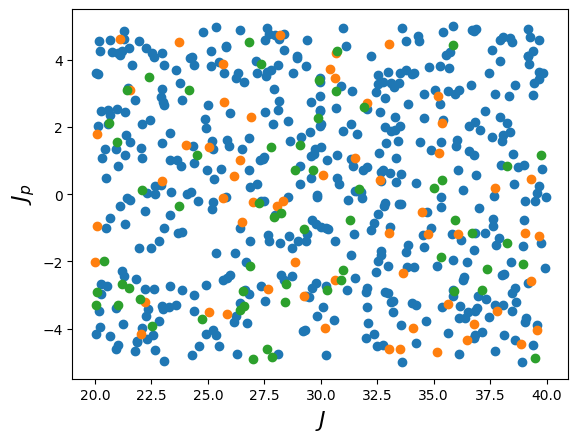

In [6]:
fig, ax = plt.subplots(1,1)
ax.scatter(spec_dataset.data_dict['params'][train_idx,0], spec_dataset.data_dict['params'][train_idx,1], label='train')
ax.scatter(spec_dataset.data_dict['params'][val_idx,0], spec_dataset.data_dict['params'][val_idx,1], label='val')
ax.scatter(spec_dataset.data_dict['params'][test_idx,0], spec_dataset.data_dict['params'][test_idx,1], label='test')
ax.set_xlabel('$J$', fontsize=16)
ax.set_ylabel('$J_{p}$', fontsize=16)


In [7]:
ax.legend()
fig.savefig('sample_split.svg', bbox_inches='tight')

In [56]:
S_pred_list = {}
S_true_list = {}

model.train()
for idx_plot in [1, 5, 35, 59]:
    S_pred_list[idx_plot] = {}
    S_pred_list[idx_plot]['S'] = []
    S_pred_list[idx_plot]['p'] = params
    S_true_list[idx_plot] = {}
    S_true_list[idx_plot]['p'] = params

    S_true_func = RegularGridInterpolator(
        (np.linspace(0, 0.5, 101), np.linspace(0, 0.5, 101), wpts.numpy()), 
        spec_dataset.data_dict['S'][test_idx[idx_plot]].reshape(-1, 101, 101).permute(1,2,0).numpy(), fill_value=0, bounds_error=False)
    S_true = S_true_func(x.detach().numpy()[...,:3])
    S_true_list[idx_plot]['S'] = S_true
    
    for i in tqdm(range(100)):
        params = spec_dataset.data_dict['params'][test_idx[idx_plot]]
        # print(params)
        # params = torch.tensor([26.85607403, -2.12352489])
        x[...,:3] = torch.cat([
            kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
            wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
        ], dim=2)
        x[...,3:] = params

        S_pred = model(x.to(model.device)).reshape(wpts.shape[0], kpts.shape[0]).detach().cpu().numpy()
        # plt.imshow(S_true, origin='lower')
        S_pred_list[idx_plot]['S'].append(S_pred)
    S_pred_list[idx_plot]['S'] = np.asarray(S_pred_list[idx_plot]['S'])

100%|██████████| 100/100 [00:00<00:00, 100.80it/s]


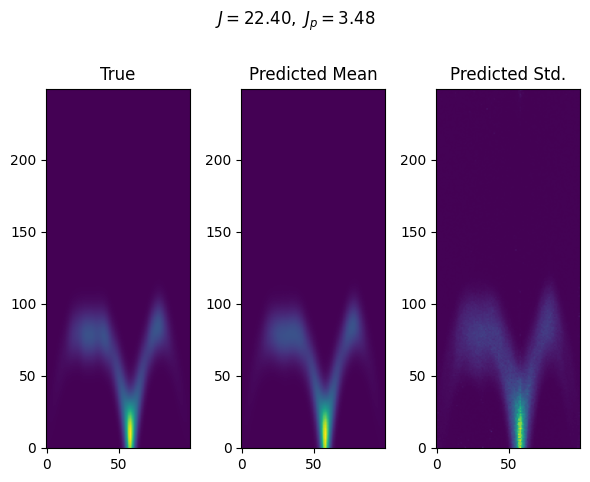

In [59]:
idx_plot = 5

fig, ax = plt.subplots(1, 3, figsize=(6, 5))
ax[0].imshow(S_true_list[idx_plot]['S'], origin='lower')
ax[0].set_title('True')
ax[1].imshow(S_pred_list[idx_plot]['S'].mean(axis=0), origin='lower')
ax[1].set_title('Predicted Mean')
ax[2].imshow(S_pred_list[idx_plot]['S'].std(axis=0), origin='lower')
ax[2].set_title('Predicted Std.')

fig.suptitle(rf"$J={S_pred_list[idx_plot]['p'][0]:.2f}, \ J_{{p}}={S_pred_list[idx_plot]['p'][1]:.2f}$")
fig.tight_layout()
fig.savefig(f"test_idx_{idx_plot}.svg", bbox_inches='tight')

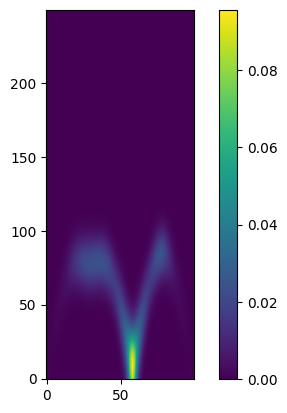

In [65]:
plt.imshow(S_pred_list[idx_plot]['S'].mean(axis=0), origin='lower')
plt.colorbar()

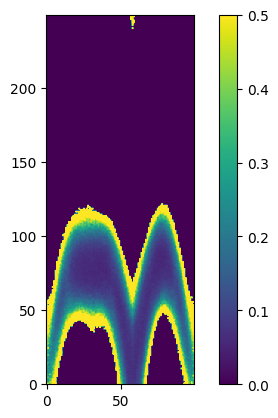

In [67]:
mask = S_pred_list[idx_plot]['S'].mean(axis=0) > (S_pred_list[idx_plot]['S'].mean(axis=0).max() * 1e-3)

plt.imshow(mask * S_pred_list[idx_plot]['S'].std(axis=0) / (S_pred_list[idx_plot]['S'].mean(axis=0).clip(0,np.inf) + 1e-6), origin='lower', vmax=0.5)
plt.colorbar()

In [45]:
S_pred_list[idx_plot]['S'].mean(axis=0).min()

-4.5548342e-05